In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, CSVLogger



Using TensorFlow backend.


In [3]:
os.chdir('/content/drive/My Drive/GitHub Repositories/State of Art Segmentation Network Architectures')
dataDir = ('./datasets/TOP-VIEW HEADS DATASET')

images = np.load(os.path.join(dataDir, 'images(8 Bit).npy'))

# Z-score Normalization
mean = np.mean(images)
std = np.std(images)
images -= mean
images /= std


masks = np.load(os.path.join(dataDir, 'masks.npy'))
# Normalize masks to [0, 1]
masks /= 255. 

print('Images: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(images.shape, images.dtype, np.amax(images), np.amin(images)))
print('Masks: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(masks.shape, masks.dtype, np.amax(masks), np.amin(masks)))

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=2020)
print('Train Images: {} | Train Masks: {}'.format(images_train.shape, masks_train.shape))
print('Validation Images: {} | Validation Masks: {}'.format(images_test.shape, masks_test.shape))


Images: (1815, 96, 128, 1) | Dtype: float32 | Max-Val: 0.5567962527275085 | Min-Val: -3.5179946422576904
Masks: (1815, 96, 128, 1) | Dtype: float32 | Max-Val: 1.0 | Min-Val: 0.0
Train Images: (1452, 96, 128, 1) | Train Masks: (1452, 96, 128, 1)
Validation Images: (363, 96, 128, 1) | Validation Masks: (363, 96, 128, 1)


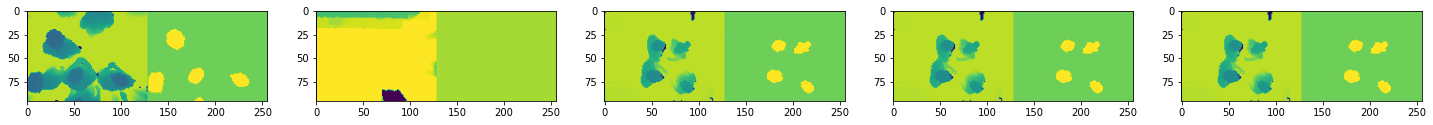

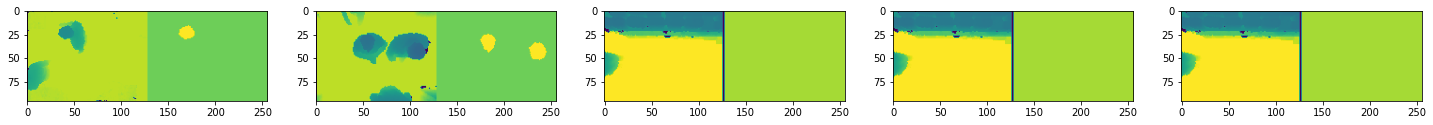

In [4]:
import matplotlib.pyplot as plt

def plotMask(images, masks):
    sample = []
    for i in range(10):
        left = images[i, :, :, 0]
        right = masks[i, :, :, 0]
        combined = np.hstack((left,right))
        sample.append(combined)
        
    for i in range(0, 10, 5):
        plt.figure(figsize=(25,10))
        
        plt.subplot(2, 5, 1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2, 5, 2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2, 5, 3+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 4+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 5+i)
        plt.imshow(sample[i+2])
        
        plt.show()

plotMask(images_test, masks_test)

In [5]:
img_rows = 96
img_cols = 128
smooth = 1
epochs = 50

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
        how many relevant items are selected. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
        how many selected items are relevant. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1score =  2 * ((precision * recall) / (precision + recall))
    return f1score

def UNET_Architecture():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    return model

model = UNET_Architecture()
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'accuracy', precision, recall, f1score])
model.summary()







Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 128, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 48, 64, 32)   0           conv2d_2[0][0]                   
______________________________________________________________________________________

ERROR! Session/line number was not unique in database. History logging moved to new session 59



Train on 1452 samples, validate on 363 samples
Epoch 1/50





1452/1452 [==============================] - 19s 13ms/step - loss: -0.0754 - dice_coef: 0.0754 - acc: 0.3096 - precision: 0.0643 - recall: 0.9640 - f1score: 0.1186 - val_loss: -0.0791 - val_dice_coef: 0.0791 - val_acc: 0.6886 - val_precision: 0.1147 - val_recall: 0.9864 - val_f1score: 0.2053
Prediction Results at epoch: 1 are below


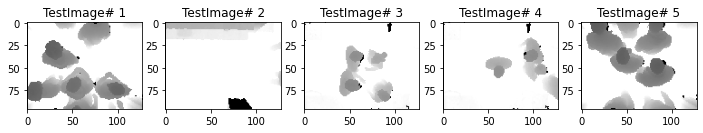

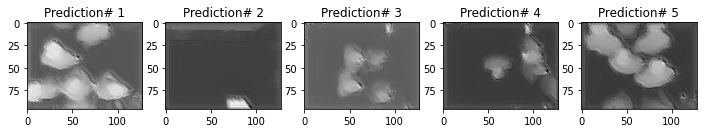

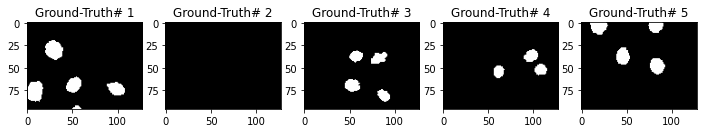

Epoch 2/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.0812 - dice_coef: 0.0812 - acc: 0.7420 - precision: 0.1332 - recall: 0.9878 - f1score: 0.2341 - val_loss: -0.0924 - val_dice_coef: 0.0924 - val_acc: 0.7688 - val_precision: 0.1482 - val_recall: 0.9818 - val_f1score: 0.2572
Epoch 3/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.1825 - dice_coef: 0.1825 - acc: 0.8621 - precision: 0.2273 - recall: 0.7607 - f1score: 0.3249 - val_loss: -0.3481 - val_dice_coef: 0.3481 - val_acc: 0.9431 - val_precision: 0.3679 - val_recall: 0.5225 - val_f1score: 0.4309
Epoch 4/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.3862 - dice_coef: 0.3862 - acc: 0.9441 - precision: 0.3917 - recall: 0.5182 - f1score: 0.4301 - val_loss: -0.3373 - val_dice_coef: 0.3373 - val_acc: 0.8805 - val_precision: 0.2252 - val_recall: 0.7859 - val_f1score: 0.3497
Epoch 5/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.4471 - dice_coe

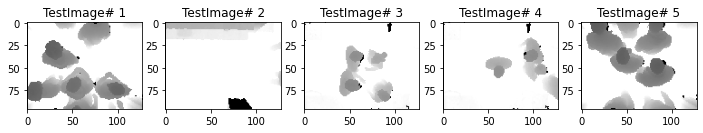

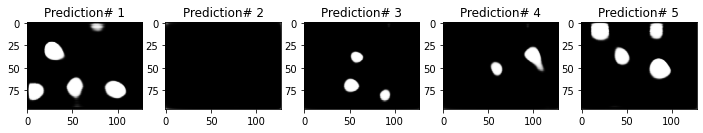

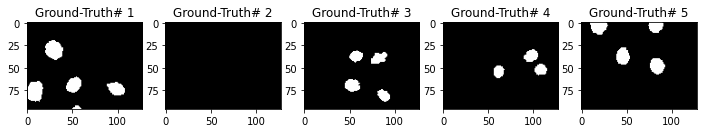

Epoch 12/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.7179 - dice_coef: 0.7179 - acc: 0.9783 - precision: 0.7285 - recall: 0.7328 - f1score: 0.7291 - val_loss: -0.7204 - val_dice_coef: 0.7204 - val_acc: 0.9793 - val_precision: 0.7919 - val_recall: 0.6775 - val_f1score: 0.7298
Epoch 13/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.7246 - dice_coef: 0.7246 - acc: 0.9787 - precision: 0.7388 - recall: 0.7374 - f1score: 0.7346 - val_loss: -0.7304 - val_dice_coef: 0.7304 - val_acc: 0.9775 - val_precision: 0.7080 - val_recall: 0.7749 - val_f1score: 0.7395
Epoch 14/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.7327 - dice_coef: 0.7327 - acc: 0.9792 - precision: 0.7429 - recall: 0.7470 - f1score: 0.7420 - val_loss: -0.7323 - val_dice_coef: 0.7323 - val_acc: 0.9803 - val_precision: 0.8121 - val_recall: 0.6814 - val_f1score: 0.7405
Epoch 15/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.7406 - dice

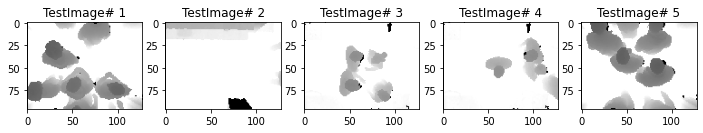

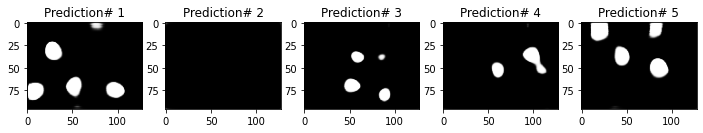

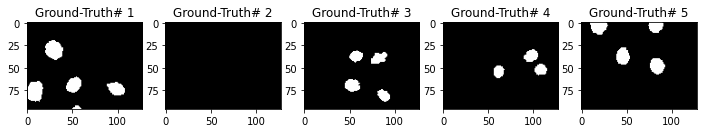

Epoch 22/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.7842 - dice_coef: 0.7842 - acc: 0.9835 - precision: 0.7969 - recall: 0.7915 - f1score: 0.7918 - val_loss: -0.7539 - val_dice_coef: 0.7539 - val_acc: 0.9769 - val_precision: 0.6648 - val_recall: 0.8887 - val_f1score: 0.7603
Epoch 23/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.7817 - dice_coef: 0.7817 - acc: 0.9828 - precision: 0.7893 - recall: 0.8000 - f1score: 0.7888 - val_loss: -0.7862 - val_dice_coef: 0.7862 - val_acc: 0.9840 - val_precision: 0.8576 - val_recall: 0.7378 - val_f1score: 0.7928
Epoch 24/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.7946 - dice_coef: 0.7946 - acc: 0.9842 - precision: 0.8076 - recall: 0.8009 - f1score: 0.8018 - val_loss: -0.7970 - val_dice_coef: 0.7970 - val_acc: 0.9831 - val_precision: 0.7723 - val_recall: 0.8399 - val_f1score: 0.8044
Epoch 25/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.8019 - dice

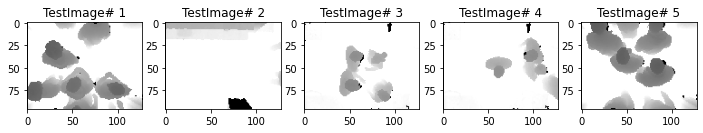

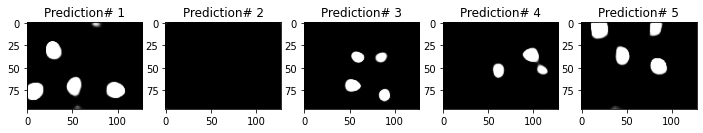

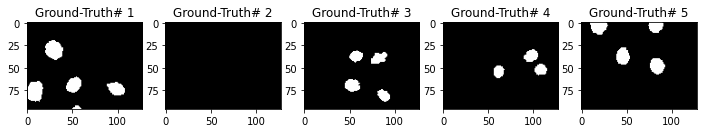

Epoch 32/50
1452/1452 [==============================] - 4s 2ms/step - loss: -0.8287 - dice_coef: 0.8287 - acc: 0.9869 - precision: 0.8407 - recall: 0.8323 - f1score: 0.8354 - val_loss: -0.8290 - val_dice_coef: 0.8290 - val_acc: 0.9864 - val_precision: 0.8402 - val_recall: 0.8310 - val_f1score: 0.8352
Epoch 33/50
1452/1452 [==============================] - 4s 2ms/step - loss: -0.8269 - dice_coef: 0.8269 - acc: 0.9866 - precision: 0.8384 - recall: 0.8334 - f1score: 0.8332 - val_loss: -0.8304 - val_dice_coef: 0.8304 - val_acc: 0.9866 - val_precision: 0.8497 - val_recall: 0.8240 - val_f1score: 0.8363
Epoch 34/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.8301 - dice_coef: 0.8301 - acc: 0.9869 - precision: 0.8398 - recall: 0.8376 - f1score: 0.8365 - val_loss: -0.8049 - val_dice_coef: 0.8049 - val_acc: 0.9858 - val_precision: 0.9151 - val_recall: 0.7272 - val_f1score: 0.8101
Epoch 35/50
1452/1452 [==============================] - 4s 2ms/step - loss: -0.8326 - dice

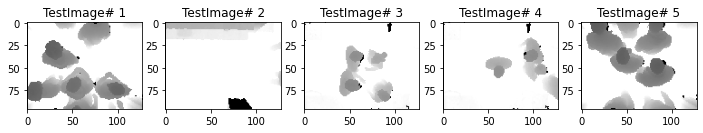

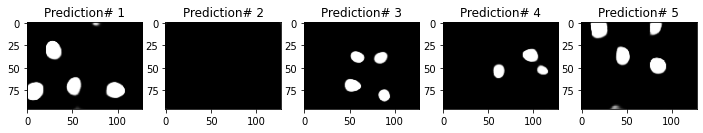

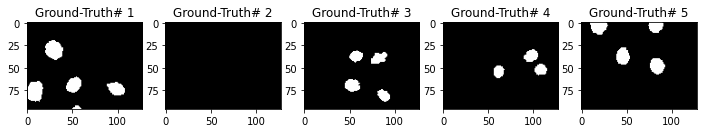

Epoch 42/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.8566 - dice_coef: 0.8566 - acc: 0.9891 - precision: 0.8695 - recall: 0.8585 - f1score: 0.8632 - val_loss: -0.8462 - val_dice_coef: 0.8462 - val_acc: 0.9872 - val_precision: 0.8145 - val_recall: 0.8954 - val_f1score: 0.8528
Epoch 43/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.8563 - dice_coef: 0.8563 - acc: 0.9890 - precision: 0.8681 - recall: 0.8600 - f1score: 0.8628 - val_loss: -0.8540 - val_dice_coef: 0.8540 - val_acc: 0.9887 - val_precision: 0.8861 - val_recall: 0.8360 - val_f1score: 0.8601
Epoch 44/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.8611 - dice_coef: 0.8611 - acc: 0.9895 - precision: 0.8742 - recall: 0.8627 - f1score: 0.8678 - val_loss: -0.8560 - val_dice_coef: 0.8560 - val_acc: 0.9886 - val_precision: 0.8717 - val_recall: 0.8529 - val_f1score: 0.8620
Epoch 45/50
1452/1452 [==============================] - 3s 2ms/step - loss: -0.8628 - dice

In [6]:

class prediction_history(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (epoch+1) % 10 == 1:
      print('Prediction Results at epoch: {} are below'.format(epoch+1))
      self.pred = model.predict(images_test)
      plot_images(images_test, self.pred, masks_test)
        
def plot_images(images_test, pred, masks_test):
  plt.figure(1, figsize = (12, 12))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('TestImage# {}' .format(i+1))
    plt.imshow(images_test[i, :, :, 0], cmap='gray')
  plt.figure(2, figsize = (12, 12))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('Prediction# {}' .format(i+1))
    plt.imshow(pred[i, :, :, 0], cmap='gray')
  plt.figure(3, figsize = (12, 12))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('Ground-Truth# {}' .format(i+1))
    plt.imshow(masks_test[i, :, :, 0], cmap='gray')
  plt.show()
  plt.close()

predictions = prediction_history()
csv_logger = CSVLogger('./saved Models/UNET Models/TOP VIEW HEADS/Training-Logs.csv')
model_checkpoint = ModelCheckpoint('./saved Models/UNET Models/TOP VIEW HEADS/best-model.h5', monitor='val_loss', save_best_only=True)

model.fit(images_train, masks_train, batch_size=32, epochs=epochs, verbose=1, shuffle=True, validation_data = (images_test, masks_test),
          callbacks=[csv_logger, model_checkpoint, predictions])